*프로젝트에 사용할 소리, 레이블데이터 압축풀기*

In [1]:
!unzip -qq "/content/drive/Othercomputers/내 컴퓨터/Scream_Detection/data.zip"

# 레이블 데이터 정리

In [2]:
from os import listdir
from os.path import join, splitext
import pandas as pd

In [3]:
label_path = '/content/data/labels/'
label_files = [
    f for f in listdir(label_path)
    if splitext(join(label_path, f))[-1] == '.txt'
]

print(
    f'label file 목록 예시 : {label_files[:3]}'
)

label file 목록 예시 : ['비명+여자+공포+연속.txt', 'laugh7.txt', '자동차출발.txt']


*레이블 정보 모음 파일 생성*

In [4]:
list_file_fn = 'file_list.xlsx'  # 파일 목록 정리 엑셀 파일
file_n = 0

with pd.ExcelWriter(list_file_fn) as writer:  # 엑셀파일 읽기
    audio_names = []    # 최종 정리를 위한 빈 리스트 생성
    for i, file_name in enumerate(label_files):
        # 레이블 데이터과 소리 데이터가 매칭이 안되는 경우 에러출력
        if file_name[:-3] + 'wav' not in listdir('/content/data/raw_data/'):
            raise FileNotFoundErrorError('file not match')

        if file_name[:-3] + 'wav' in listdir('/content/data/raw_data/'):
            temp = pd.read_csv(label_path + file_name, sep='\t', header=None)
            temp.columns = ['start(s)', 'end(s)', 'label']
            temp.to_excel(writer, index=False, sheet_name=str(file_n))  # i번째 인덱스 이름의 sheet에 레이블 정보 저장
            audio_names.append(file_name[:-3] + 'wav')      # 현재 저장한 레이블에 해당하는 소리파일 목록 넣기
            file_n += 1

        if i == len(label_files) - 1:  # 마지막 반복때 모든 파일의 목록 저장
            pd.DataFrame(
                audio_names, columns=['audio_name']
            ).to_excel(writer, sheet_name='list')

한 파일에 대한 레이블 
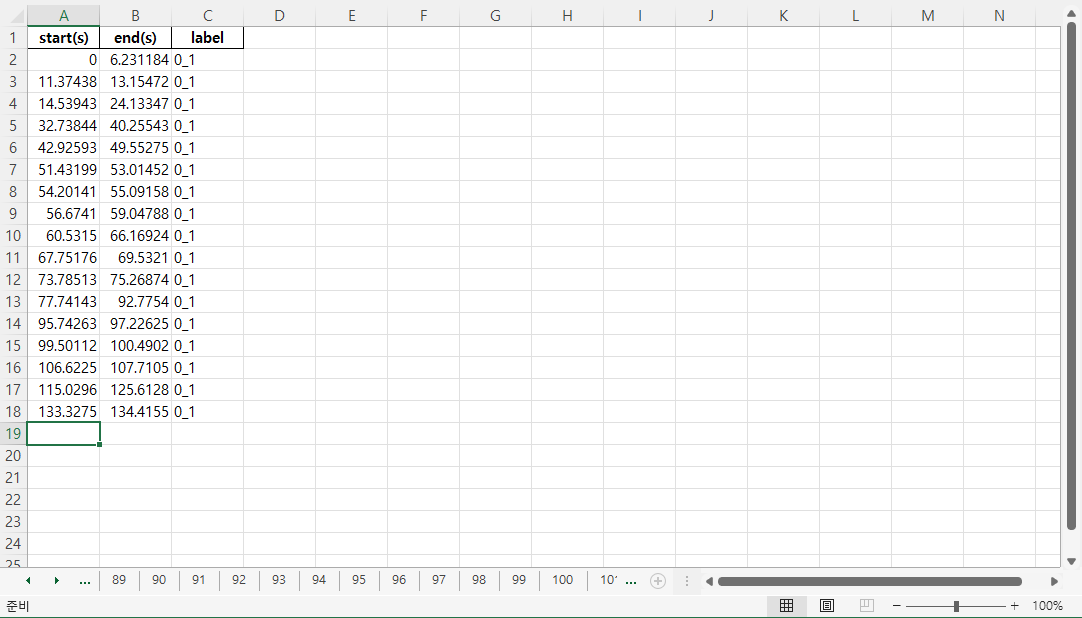

파일 리스트 정리
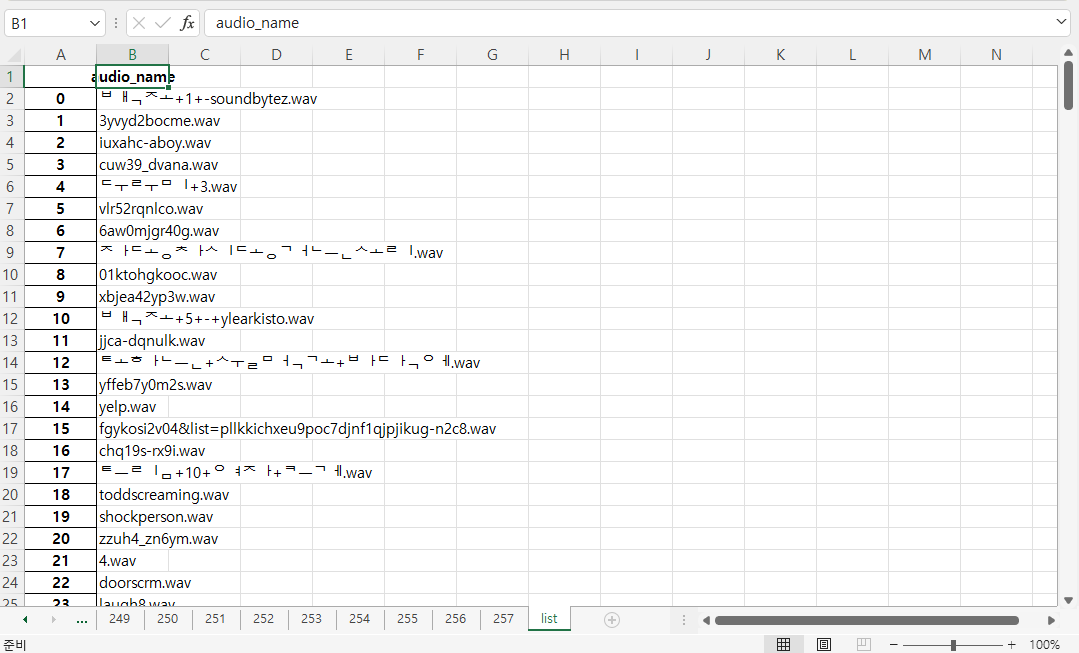

# 전체 데이터 전처리

In [5]:
import time
import math

import numpy as np
import pandas as pd

import librosa

*Function of data load*

In [6]:
# 소리 데이터 로드
def load_sound_data(file_path, sampling_rate):
    audio, sr = librosa.load(file_path, sr=sampling_rate)
    return audio, sr

In [7]:
# 레이블 데이터 로드 및 일정 시간 미만의 레이블 제거
def load_label_data(file_path, i, frame_size):
    audio_label = pd.read_excel(file_path, sheet_name=str(i))  # 데이터를 정리한 엑셀 파일의 i번 sheet 덩보 불러오기
    audio_label['label'] = audio_label['label'].apply(
        lambda x: int(str(x)[0])
    )
 
    audio_label = np.array(audio_label)  # Pandas -> numpy
    audio_label = audio_label[
        (audio_label[:, 1] - audio_label[:, 0] > frame_size)
    ]                                    # 실제로 사용할 Frame size 이하 레이블은 버림
    
    return audio_label

*Function of frame processing*

In [8]:
def process_frame(audio, sr, label, frame_size, stride):
    n = np.sum(
        np.floor(((label[:, 1] - label[:, 0]) - frame_size) / stride + frame_size)
    )                                    # 총 Frame 개수
 
    # Frame 벡터, Target벡터(Label 벡터)를 담을 빈 벡터 생성
    frame_vector = np.zeros((int(n), frame_size * sr))
    target_vector = np.zeros((int(n), 1))
 
    i = 0
    for temp_label in label:    # 한 개의 레이블 구간 처리
        start = temp_label[0]   # 시작시점
        end = temp_label[1]     # 종료시점
        y = temp_label[2]       # 레이블 정보
 
        eter = int(
            np.floor((((end - start) - frame_size) / stride) + 1)
        )                                # 레이블 별 Frame 개수
 
        for j in range(eter):   # 레이블 별 Frame 처리 
            start_idx = int((start + j * stride) * sr)
            end_idx = start_idx + frame_size * sr
            frame_vector[i] = audio[start_idx:end_idx]      # Frame 벡터에 값 넣기
            target_vector[i] = y    # Target 벡터에 값 넣기
            i += 1

    return frame_vector, target_vector

*Funtion of feature extraction: Mel Spectrogram*

In [9]:
def extract_mel_feature(frame_vector, sr, n_mels, st=512):
    mel_feature = librosa.feature.melspectrogram(
        y=frame_vector, sr=sr, n_mels=n_mels, hop_length=st
    )                               # Mel Spectrograme 추출
    mel_feature = librosa.power_to_db(
        mel_feature, ref=np.max
    )                               # power -> dB로 변환
    return mel_feature

*Frame Processing*

In [10]:
sr = 22050
frame_size = 1
stride = 0.2

file_list = pd.read_excel('./file_list.xlsx', sheet_name='list')
 
frame_vectors = []
label_vectors = []
idx_count = []
 
for file_i, file_name in enumerate(file_list['audio_name']):    # 각 파일마다 처리
    if file_i % 10 == 0:
        print(f'{file_i}-th 파일을 처리하고 있습니다.')
 
    label_data_temp = load_label_data(
        './file_list.xlsx', file_i, frame_size
    )                                       # 해당 파일의 레이블 정보
 
    if len(label_data_temp) == 0:       # frame size보다 긴 레이블이 없는 경우 예외처리
        idx_count.append(0)
        continue
 
    audio_path = './data/raw_data/' + file_name
    audio_data_temp, _ = load_sound_data(audio_path, sr)
 
    frame_vector, label_vector = process_frame(
        audio=audio_data_temp, sr=sr, label=label_data_temp,
        frame_size=frame_size, stride=stride
    )                                       # Frame Processing

    frame_vectors.append(frame_vector)
    label_vectors.append(label_vector)
    
    idx_count.append(frame_vector.shape[0])

# 각 파일에서 얻은 frame, label 벡터 합치기   
frame_vectors = np.concatenate(frame_vectors)
label_vectors = np.concatenate(label_vectors)

0-th 파일을 처리하고 있습니다.
10-th 파일을 처리하고 있습니다.
20-th 파일을 처리하고 있습니다.
30-th 파일을 처리하고 있습니다.
40-th 파일을 처리하고 있습니다.
50-th 파일을 처리하고 있습니다.
60-th 파일을 처리하고 있습니다.
70-th 파일을 처리하고 있습니다.
80-th 파일을 처리하고 있습니다.
90-th 파일을 처리하고 있습니다.
100-th 파일을 처리하고 있습니다.
110-th 파일을 처리하고 있습니다.
120-th 파일을 처리하고 있습니다.
130-th 파일을 처리하고 있습니다.
140-th 파일을 처리하고 있습니다.
150-th 파일을 처리하고 있습니다.
160-th 파일을 처리하고 있습니다.
170-th 파일을 처리하고 있습니다.
180-th 파일을 처리하고 있습니다.
190-th 파일을 처리하고 있습니다.
200-th 파일을 처리하고 있습니다.
210-th 파일을 처리하고 있습니다.
220-th 파일을 처리하고 있습니다.
230-th 파일을 처리하고 있습니다.
240-th 파일을 처리하고 있습니다.
250-th 파일을 처리하고 있습니다.


In [11]:
print(
    f'label vectors 의 shape: {label_vectors.shape}\
    \n비명 갯수 : {int(sum(label_vectors == 1))}\
    \n비명 아닌 갯수 : {int(sum(label_vectors == 0))}'
)

label vectors 의 shape: (6090, 1)    
비명 갯수 : 2237    
비명 아닌 갯수 : 3853


*Frame Vector -> Mel Spectrogram*

In [12]:
n_mels = 64

mel_features = []
for frame_vector in frame_vectors:
    mel_feature = extract_mel_feature(
        frame_vector=frame_vector, sr=sr, n_mels=n_mels
    )
    mel_features.append(mel_feature)        # 각 frame vector 별 mel spectrogram 추출
mel_features = np.stack(mel_features)       # 모든  mel spectrogram 합치기

print(f'mel spectrogram shape: {mel_features.shape}')

mel spectrogram shape: (6090, 64, 44)


# Dataset & DataLoader

In [13]:
from torch.utils.data import Dataset, DataLoader

*train, valid 데이터 나누기*

In [14]:
train_ratio = 0.7  	# 학습 데이터의 비율은 70%

total_n = frame_vectors.shape[0]  	# 전체 데이터 개수
train_n = int(total_n * train_ratio)  	# 학습 데이터 개수

# 학습에 사용할 인덱스 무작위 추출
train_idxes = np.random.choice(total_n, train_n, replace=False)  # 전체 데이터 중 학습 데이터 개수만큼 추출

index_mask = np.zeros(shape=total_n, dtype=bool)
index_mask[train_idxes] = True  	# 추출한 인덱스의 값을 True로 변환

print(train_idxes[:10])
print(index_mask[:10])

[ 710 3697 4341 4676 3879 5447 3501 5654 2136 5947]
[ True  True  True  True  True  True  True  True  True False]


In [15]:
# 학습 데이터는 True값 , 검증 데이터는 False값 추출 (7:3)
train_mel_features = mel_features[index_mask]
valid_mel_features = mel_features[~index_mask]

train_label_vectors = label_vectors[index_mask]
valid_label_vectors = label_vectors[~index_mask]

In [16]:
print(f'train mel shape: {train_mel_features.shape}')
print(f'valid mel shape: {valid_mel_features.shape}')
print(f'train label shape: {train_label_vectors.shape}')
print(f'valid label shape: {valid_label_vectors.shape}')

train mel shape: (4263, 64, 44)
valid mel shape: (1827, 64, 44)
train label shape: (4263, 1)
valid label shape: (1827, 1)


*Dataset 커스텀 클래스*

In [17]:
class ScreamDataset(Dataset):
    def __init__(self, x, y):
        self.audio_features = x
        self.labels = y
    
    def __len__(self):
        return len(self.audio_features)
    
    def __getitem__(self, idx):
        audio_feature = torch.FloatTensor(self.audio_features[idx])
        audio_feature = audio_feature.unsqueeze(0)
        label = self.labels[idx]
        return (audio_feature, label)

In [18]:
batch_size = 128

# 학습을 위한 dataset, dataloader
train_dataset = ScreamDataset(
    train_mel_features, train_label_vectors
)  
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)  

# 검증을 위한 dataset, dataloader
valid_dataset = ScreamDataset(
    valid_mel_features, valid_label_vectors
)  
valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False
)  

# 네트워크 구성

In [33]:
import torch
from torch import nn
import torch.nn.functional as F

In [40]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()

        # Convolution Layer
        self.conv1 = nn.Conv2d(1, 32, (64, 1))
        self.conv2 = nn.Conv2d(32, 64, (1, 9), stride=4)

        # Nomalization Layer
        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)

        # fully connected layer
        self.fc1 = nn.Linear(64*1*9, 1)

        # 활성화 함수 ReLU
        self.relu = nn.ReLU()

    def forward(self, x):

        # Conv -> Nomalization -> ReLU -> Dropout
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)
        x = F.dropout2d(x, p=0.3, training=self.training)

        # Conv -> Nomalization -> ReLU -> Dropout
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x)
        x = F.dropout2d(x, p=0.3, training=self.training)

        # Flatten -> Fully-connected
        x = x.view(-1, 64*1*9)
        x = self.fc1(x)

        return x

# 모델 학습 및 검증

In [41]:
from torch import optim
from sklearn.metrics import f1_score, accuracy_score

In [53]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")    # GPU 존재시 GPU 실행(CUDA)
cnn = CNN_model().to(DEVICE)

learning_rate = 0.001
epochs = 100

criterion = nn.BCEWithLogitsLoss()  # Sigmoid + BCELoss
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)  # adam optimizer 사용, 학습률은 0.001

*훈련 데이터로 학습하여 모델화*

In [54]:
def train(model, train_loader, optimizer):
    train_loss = 0
    train_acc = 0
    train_f1_score = 0

    train_n = len(train_dataset)    # 전체 훈련 데이터 개수

    model.train()  # 모델을 train모드로 설정(Dropout 적용)
    for audio_feature, label in train_loader:
        audio_feature = audio_feature.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()  # optimizer 초기화(Gradient)
        
        output = model(audio_feature)  # 비명 확률 logit
        
        loss = criterion(output, label)  # Loss 값 계산
        loss.backward()  # 역전파로 Gradient를 계산 후 파라미터에 할당
        optimizer.step()  # 파라미터 업데이트

        output = torch.round(torch.sigmoid(output))  # 모델의 결과 값(확률)을 통해 비명 여부 도출
        # 메모리측면에서 텐서는 GPU에서 연산처리, numpy는 cpu에서 처리하기 떄문에 gpu->cpu로 옮길 필요가 있음
        output = output.cpu().detach().numpy()
        label = label.cpu().detach().numpy()

        acc = accuracy_score(label, output)  # 정확도 계산
        f1 = f1_score(label, output)    # f1_score 계산

        n = len(label)  # 값 보정을 위한 해당 Batch의 데이터 개수 추출
        train_loss += loss.item() * n
        train_acc += acc.item() * n
        train_f1_score += f1 * n

    # 전체 데이터로 값 보정
    train_loss /= train_n
    train_acc = 100.0 * train_acc / train_n
    train_f1_score /= train_n

    return train_loss, train_acc, train_f1_score

*모델 검증*

In [55]:
def evaluate(model, test_loader):
    valid_loss = 0
    valid_acc = 0
    valid_f1_score = 0

    valid_n = len(valid_dataset)

    model.eval()    # 모델을 eval모드로 설정(Dropout 미적용)
    with torch.no_grad():       # Gradient 계산 비활성화 (모델 평가에는 파라미터 업데이트 X)
        for audio_feature, label in valid_loader:
            audio_feature = audio_feature.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(audio_feature)

            loss = criterion(output, label)

            output = torch.round(torch.sigmoid(output))
            # train 모드와는 달리 gradient가 전파가 안되므로 detach()가 필요 없다.
            output = output.cpu().numpy()
            label = label.cpu().numpy()
            
            acc = accuracy_score(label, output)
            f1 = f1_score(label, output)

            n = len(label)
            valid_acc += acc.item() * n
            valid_loss += loss.item() * n
            valid_f1_score += f1 * n
    
    # 전체 데이터로 값 보정
    valid_loss /= valid_n
    valid_acc = 100.0 * valid_acc / valid_n
    valid_f1_score /= valid_n

    return valid_loss, valid_acc, valid_f1_score

*모델 학습 실행*

In [56]:
# Overfitting/Underfitting 확인용
loss_tr = []
acc_tr = []
loss_val = []
acc_val = []

for epoch in range(1, epochs + 1):       # epoch 30번 실행
    tr_loss, tr_acc, tr_f1_score = train(cnn, train_loader, optimizer)
    val_loss, val_acc, val_f1_score = evaluate(cnn, valid_loader)

    print(f'Epoch {epoch+0 : 03}')
    print('      |   loss  |   acc   |   f1   |')
    print(f'TRAIN | {tr_loss : .4f} | {tr_acc :.2f} % | {tr_f1_score : .3f} |')
    print(f'VALID | {val_loss : .4f} | {val_acc :.2f} % | {val_f1_score : .3f} |')
    print('----------------------------------')
    
    loss_tr.append(tr_loss)
    loss_val.append(val_loss)
    acc_tr.append(tr_acc/100)
    acc_val.append(val_acc/100)

torch.save(cnn.cpu().state_dict(), 'test.pth')    # 모델 저장

Epoch  01
      |   loss  |   acc   |   f1   |
TRAIN |  0.4329 | 81.00 % |  0.731 |
VALID |  0.3546 | 85.22 % |  0.736 |
----------------------------------
Epoch  02
      |   loss  |   acc   |   f1   |
TRAIN |  0.3285 | 86.42 % |  0.810 |
VALID |  0.3140 | 86.70 % |  0.759 |
----------------------------------
Epoch  03
      |   loss  |   acc   |   f1   |
TRAIN |  0.2715 | 89.26 % |  0.851 |
VALID |  0.2917 | 87.41 % |  0.769 |
----------------------------------
Epoch  04
      |   loss  |   acc   |   f1   |
TRAIN |  0.2604 | 89.51 % |  0.854 |
VALID |  0.3086 | 87.47 % |  0.774 |
----------------------------------
Epoch  05
      |   loss  |   acc   |   f1   |
TRAIN |  0.2546 | 89.73 % |  0.857 |
VALID |  0.2830 | 88.23 % |  0.779 |
----------------------------------
Epoch  06
      |   loss  |   acc   |   f1   |
TRAIN |  0.2408 | 90.99 % |  0.874 |
VALID |  0.2385 | 90.91 % |  0.822 |
----------------------------------
Epoch  07
      |   loss  |   acc   |   f1   |
TRAIN |  0.2145 |

# Overfitting / Underfitting 손실값으로 판별

In [57]:
import matplotlib.pyplot as plt

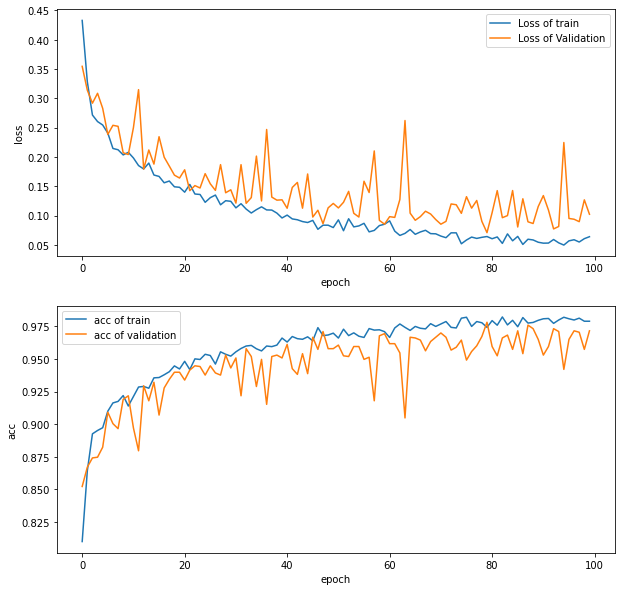

In [59]:
np1 = np.array(loss_tr)
np2 = np.array(loss_val)
np3 = np.array(acc_tr)
np4 = np.array(acc_val)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(np1, label='Loss of train')
plt.plot(np2, label='Loss of Validation')
plt.legend()  # 라벨표시를 위한 범례

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot(np3, label='acc of train')
plt.plot(np4, label='acc of validation')
plt.legend()  # 라벨표시를 위한 범례
plt.show()